# Integrating mouse embryo cell atlas data using scVI
In this notebook, we will use scVI ([Deep generative modeling for single-cell transcriptomics](https://doi.org/10.1038/s41592-018-0229-2)) to integrate the concatenated dataset of stage 5.5 mouse embryo data created in "concat_datasets.ipynb".

We measure the quality of integration with metrics from [_Luecken, M.D., Büttner, M., Chaichoompu, K. et al. Benchmarking atlas-level data integration in single-cell genomics. Nat Methods 19, 41–50 (2022)._](https://doi.org/10.1038/s41592-021-01336-8)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import scib
import scanpy as sc
import scvi

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  tensorboard.__version__
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0


In [3]:
adata_orig = sc.read('../data/raw_e55/Concatenated_E55.h5ad')

In [4]:
adata = sc.read('../data/raw_e55/Concatenated_E55.h5ad')
adata

AnnData object with n_obs × n_vars = 12239 × 15456
    obs: 'cell_type', 'batch_id', 'batch'
    var: 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_id_colors', 'cell_type_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.layers['counts'] = adata.X.copy()
adata.obs['cell_type'].astype('category')

EB_1006-0          VE
EB_1007-0         EPI
EB_1010-0          VE
EB_1009-0          VE
EB_1011-0          VE
                 ... 
SS.sc7785265-3    ExE
SS.sc7785266-3     VE
SS.sc7785267-3     VE
SS.sc7785268-3    EPI
SS.sc7785269-3     VE
Name: cell_type, Length: 12239, dtype: category
Categories (5, object): ['EPI', 'ExE', 'VE', 'emVE', 'exVE']

Subset to highly variable genes

In [6]:
adata_raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    batch_key="batch_id",
    subset=True
)

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


### Setup the scVI model

In [7]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch_id", layer="counts")

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [8]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

### Train the model

In [9]:
vae.train()

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [06:21<00:00,  1.05it/s, loss=1.02e+03, v_num=1]


Store the resulting latent representation

In [10]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

### Save the new anndata to a file

In [11]:
sc.write('data_copy/scVI_integrated.h5ad', adata)

In [12]:
adata = sc.read('data_copy/scVI_integrated.h5ad')

## Visualize the integrated data

Use a coarse resolution to get leiden clusters ~ cell types

In [13]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)

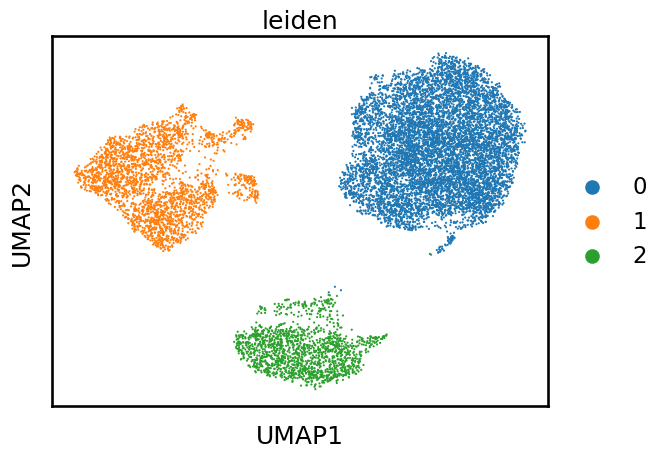

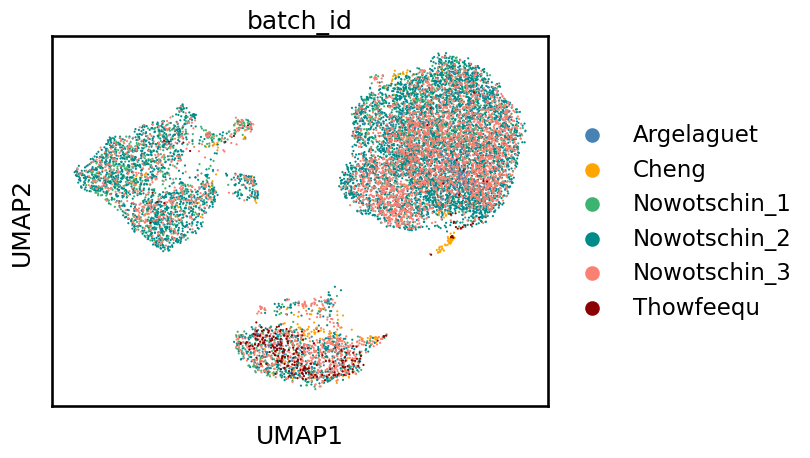

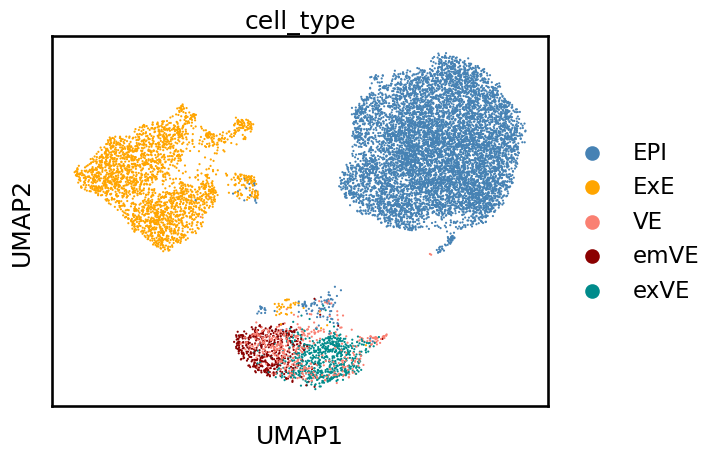

In [14]:
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['batch_id'])
sc.pl.umap(adata, color=['cell_type'])

### t-SNE

In [15]:
sc.tl.tsne(adata, use_rep="X_scVI")

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


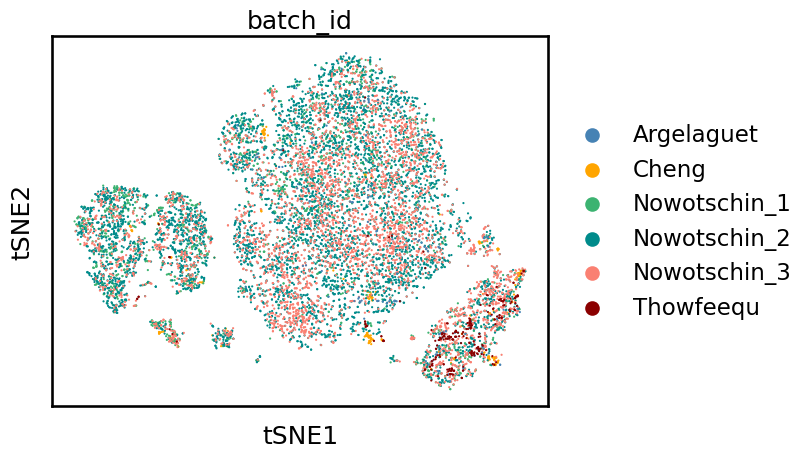

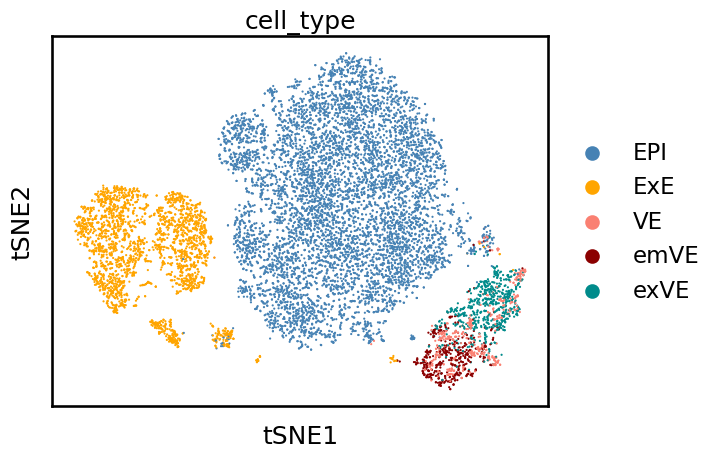

In [16]:
sc.pl.tsne(adata, color=['batch_id'])
sc.pl.tsne(adata, color=['cell_type'])

### Diffusion map

In [17]:
sc.tl.diffmap(adata)

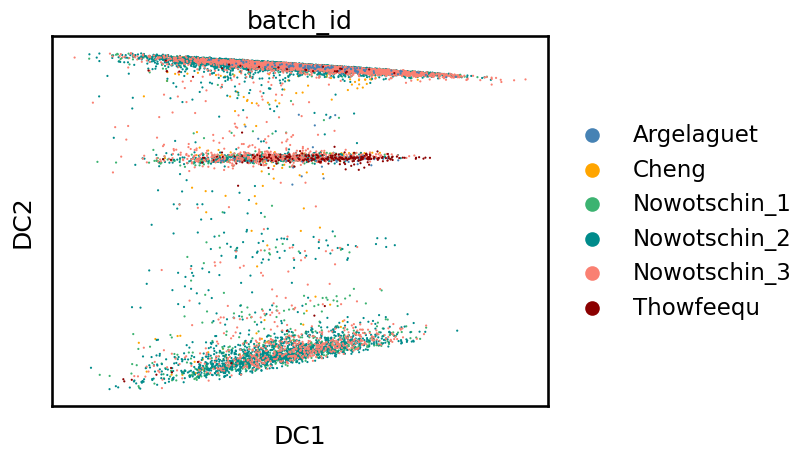

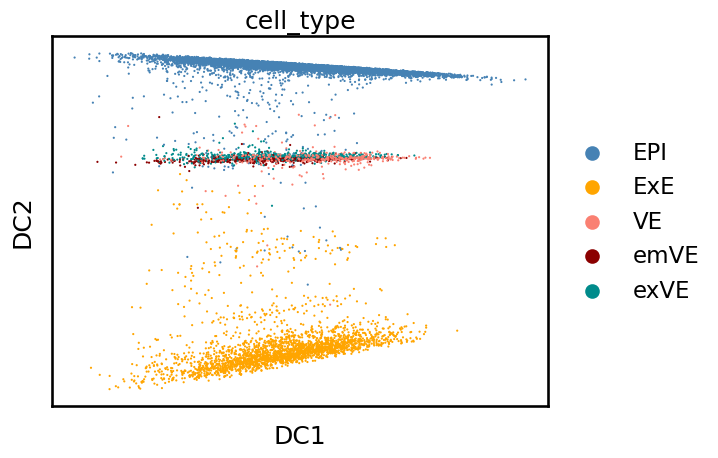

In [18]:
sc.pl.diffmap(adata, color=['batch_id'])
sc.pl.diffmap(adata, color=['cell_type'])

### Analysis
Looking at the above plots of the calculated latent representation, we can argue, that the integration worked well. The batches are somewhat mixed, and the cell types still cluster together.

### Calculate Metrics

Use metrics wrapper function to manually unselect trajectory conservation.

In [19]:
# scvi_metrics = scib.metrics.metrics_all(adata_orig, adata, batch_key='batch_id', label_key='cell_type', embed='X_scVI')
scvi_metrics = scib.metrics.metrics(adata_orig, adata, batch_key='batch_id', label_key='cell_type', embed='X_scVI', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_=False, kBET_=True, lisi_graph_=True,
                        ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=False)

/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/metrics/metrics.py:302: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  force=True,


NMI...
ARI...
Silhouette score...
PC regression...
cell cycle effect...


/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  np.array(score).ravel(), index=adata.obs_names, dtype='float64'
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.o

Isolated labels F1...
Compute neighbors on rep X_scVI
Compute neighbors on rep X_scVI
Isolated labels ASW...
Graph connectivity...
kBET...


/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:266: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/numpy2ri.py:208: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)


cLISI score...


/home/ubuntu/miniconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore")


iLISI score...


In [20]:
scvi_metrics.style\
    .set_caption("<h3>scVI metrics</h3>")\
    .background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")

,0
NMI_cluster/label,0.862149
ARI_cluster/label,0.947446
ASW_label,0.571223
ASW_label/batch,0.941723
PCR_batch,0.979306
cell_cycle_conservation,0.843177
isolated_label_F1,0.756531
isolated_label_silhouette,0.590095
graph_conn,0.994842
kBET,0.640394
